# Clustering: DBSCAN
`Javi GG`

<center><img src="https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/53842/versions/4/screenshot.png" alt="png" style="zoom:60%;" /></center>

DBSCAN es uno de los algoritmos de clustering más usados y citados. Propuesto por Martin Ester, Hans-Peter Kriegel, Jörg Sander y Xiaowei Xu en 1996, DBSCAN es un algoritmo de referencia cuando los datos no son linealmente separables.

DBSCAN nos ofrece una serie de ventajas. Por ejemplo, no es necesario ir estudiando los contradictorios coeficientes GAP o Silhouette para encontrar el número óptimo de clústers ya que DBSCAN no necesita saber el número de grupos a priori. Otra de las ventajas es que puede encontrar clusters con formas geométricas de toda índole, como ahora veremos.

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
import pandas as pd
from sklearn.preprocessing import scale
plt.style.use('seaborn-whitegrid')
import matplotlib.patches as patches
from sklearn.cluster import KMeans

## Carga de datos

Hoy trabajaremos con el siguiente dataset que he creado usando esta utilísima web;  <a href="https://drawdata.xyz" target="_blank" rel="noopener">drawdata.xyz</a>

$$\Lambda = \{(x_i, y_i) , x_i \in X, y_i \in \{amarillo, verde, azul\} \}^m_{i=1} $$

Donde tenemos una serie de observaciones que pertenecen a tres clases diferentes; *amarillo*, *verde* y *azul*. El objetivo es encontrar estas clases de forma no-supervisada, mediante clustering.

In [2]:
df = pd.read_csv('data.csv')
X = np.hstack((df.x.values.reshape(-1,1),df.y.values.reshape(-1,1)));
Y = df.z.replace({'a':0, 'b':1, 'c':2}).values
X = scale(X)

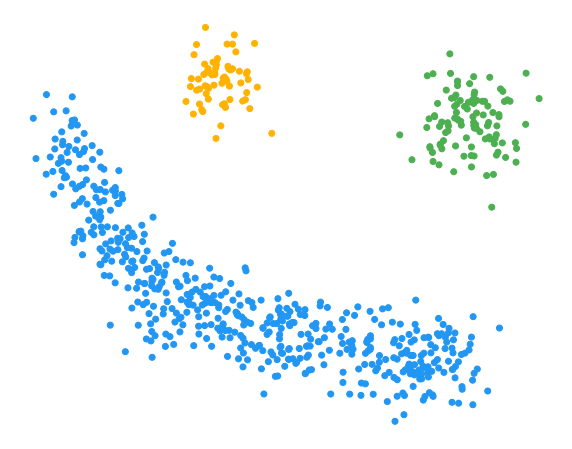

In [3]:
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = df.z.replace({'a':'#FFB300', 'b':'#4CAF50', 'c':'#2196F3'}))
plt.grid(False)
plt.axis('off')
plt.show()
#fig.savefig('clustering-dbscan.png', transparent=True)

## K-means

Algoritmos tan famosos como k-means no van a poder encontrar una solución satisfactoria para la clasificación de estas regiones ya que estos datos no son separables de forma lineal. <mark>K-means no es siempre la única solución!</mark>

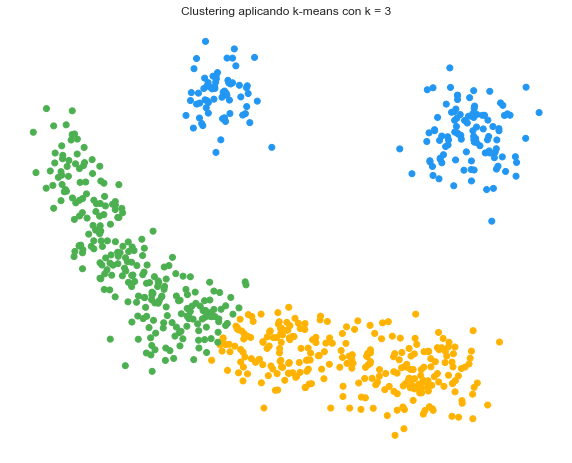

In [4]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['clust_kmeans'] = kmeans.labels_
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = df.clust_kmeans.replace({0:'#FFB300', 1:'#4CAF50', 2:'#2196F3', 3:'#ff1744'}))
plt.grid(False)
plt.axis(False)
plt.title('Clustering aplicando k-means con k = 3')
plt.show()

## DBSCAN

DBSCAN calcula la densidad de cada región contando el número de *vecinos* de cada observación en nuestro dataset. Los *vecinos* de una observación $x_i$ serán todas aquellas observaciones que se encuentren a un radio $\epsilon$. Definimos por tanto los vecinos de una observación $x_i$ como:

$$N_{Eps}(x_i) = \{x_j \in D : d(x_j, x_i) < \epsilon \}$$

Donde $D$ es la matriz de datos y $d(x_j, x_i)$ la distancia euclídea entre $x_j$ y $x_i$.

### <font color='blue'> Construcción del grafo de los vecinos a un radio $\epsilon$ </font>

In [5]:
dist_matrix = pairwise_distances(X)
# Función que nos devuelve los índices de las observaciones vecinas para cada observación
def vecinos_a_eps(X, eps, d):
    return [ [index for index, d in enumerate(dist_matrix[i,:]) if d < eps] for i in range(X.shape[0]) ]

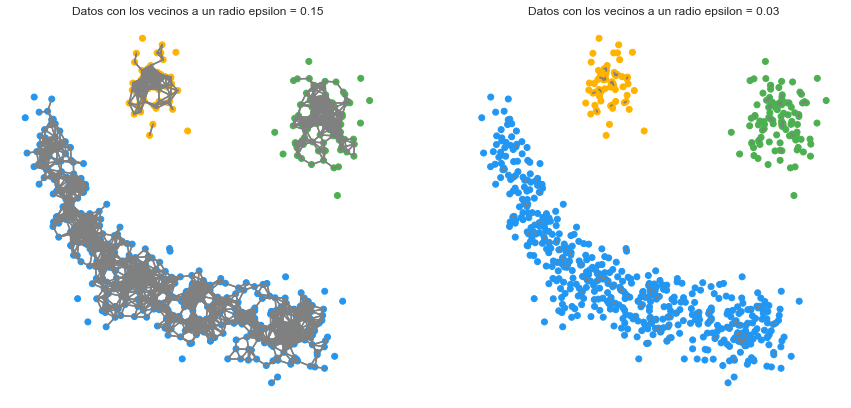

In [24]:
fig = plt.figure(figsize=(15,7))
for ind_plot, epsilon in zip(range(1, 3), [0.15, 0.03]):
    plt.subplot(1, 2, ind_plot)
    plt.scatter(X[:,0], X[:,1], c = df.z.replace({'a':'#FFB300', 'b':'#4CAF50', 'c':'#2196F3'}))
    vecinos = vecinos_a_eps(X, epsilon, dist_matrix)
    for i in range(X.shape[0]):
        veins = vecinos[i]
        for j in range(len(veins)):
            plt.plot(X[[i, veins[j]], 0], X[[i, veins[j]], 1], c='gray')
    plt.grid(False)
    plt.axis(False)
    plt.title('Datos con los vecinos a un radio epsilon = {}'.format(epsilon))
    
plt.show()

Uno de los parámetros iniciales de DBSCAN es $\epsilon$  (radio de la circunferencia). Este hiperparámetro es crítico ya que si escogemos un valor de $\epsilon$ demasiado grande, todos los puntos serán vecinos ya que la circunferencia podría abarcarlos a todos y se encontraría tan solo un clúster. Pero si $\epsilon$ es demasiado pequeño, cada observación solo tendría un único vecino (él mismo) y habrían tantos clústeres como observaciones.

Una posible solución para encontrar los clústers sería obligar a que todos los puntos pertenecientes a un clúster tengan un número prefijado de vecinos:

$$|N_{Eps}| \geq MinPts$$

Pero no todos los puntos tienen por qué cumplir esta condición, van a existir diferentes tipos de estos.

### Clases de puntos

Hay tres clases de puntos diferenciales en un clúster, los puntos que se encuentran dentro del clúster (*puntos núcleo*), los puntos en la frontera del clúster (*puntos frontera*) y los que no pertenecen al clúster (*puntos ruido*).  Se define cada uno de ellos como:

- **Puntos núcleo:** Si el número de vecinos es al menos un valor prefijado ($MinPts$)
- **Puntos frontera:** Si es vecino de un punto núcleo
- **Puntos ruido:** Si no es núcleo ni frontera

### <font color='blue'> Ejemplo de clases de puntos </font>

In [21]:
vecinos = vecinos_a_eps(X, 0.15, dist_matrix)
xi_nn = []
for i in range(len(vecinos)):
    xi_nn.append(X[vecinos[i]])
xi_nn = np.array(xi_nn)

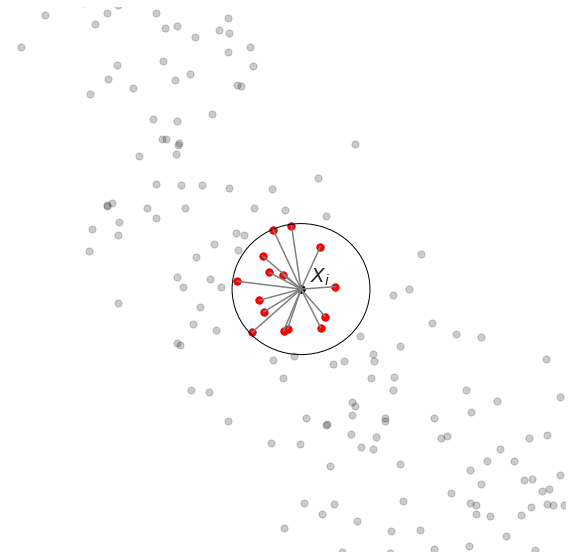

In [22]:
fig = plt.figure(figsize=(10,10))
i_x = 245
plt.scatter(X[i_x, 0], X[i_x, 1], c='blue', s=50, alpha=0.8)
plt.text(X[i_x, 0] + 0.02, X[i_x, 1] + 0.015, s='$X_i$', size=20)
plt.scatter(X[vecinos[i_x], 0], X[vecinos[i_x], 1], c='red', alpha = 0.8, s=50)
circ = patches.Circle((X[i_x][0],X[i_x][1]),0.15, color='black', fill=False)
plt.gca().add_patch(circ)
for i in range(len(vecinos[i_x])):
    plt.plot(X[[i_x, vecinos[i_x][i]], 0], X[[i_x, vecinos[i_x][i]], 1], c='gray')
plt.scatter(X[:,0], X[:,1], alpha=0.2, c='black', s=50);
plt.scatter(X[vecinos[i_x], 0], X[vecinos[i_x], 1], c='red', alpha = 0.8, s=50)
plt.scatter(X[i_x][0], X[i_x][1], c='black', s=50)
plt.xlim(np.min(xi_nn[i_x][:,0])-0.5,np.max(xi_nn[i_x][:,0])+0.5)
plt.ylim(np.min(xi_nn[i_x][:,1])-0.5,np.max(xi_nn[i_x][:,1])+0.5);
plt.grid(False)
plt.axis('off')
fig.savefig('circle-neigh-dbscan.png', transparent=True)

En este caso, $|N_{Eps}(x_i)| = 15$. Si tomamos un valor de $MinPts$ de 5, $x_i$ sería un punto núcleo y sus vecinos serían puntos frontera con respecto a $x_i$.

### Relaciones entre puntos

En general, los *puntos núcleo* van a tener un número de vecinos mucho mayor que un *punto frontera*. Por tanto, para cada punto $p$ del clúster, habrá un punto $q$ dentro del clúster de forma que $p$ será vecino de $q$ y $q$ tendrá al menos $MinPts$ vecinos. En este caso, diremos que **$p$ es densamente directamente alcanzable desde $q$.** De forma más formal;

*Un punto $p$ es densamente directamente alcanzable desde $q$ si:*

$$ p \in N_{Eps}(q) \;\; \wedge \;\; |N_{Eps}(q)| \geq MinPts $$

Por otra parte, diremos que un punto $p$ es **densamente alcanzable** desde $q$ (punto núcleo) si existe una secuencia de puntos desde $q$ hasta $p$ ; $q,p_1, p_2,..., p$ de forma que $p_{i+1}$ es densamente directamente alcanzable desde $p_i$. O sea, si existe una secuencia de puntos densamente directamente alcanzables entre $p$ y $q$.

Con estas definiciones, dos puntos frontera no serían densamente alcanzables ya que ninguno cumpliría las propiedades de un punto núcleo. Pero en un clúster dos puntos frontera sí se pueden alcanzar, para terminar de definir la conectividad de un clúster debemos definir un último concepto; dos puntos $p$ y $q$ están **densamente conectados** si existe un punto $o$ tal que ambos $p$ y $q$ sean densamente alcanzables desde $o$.

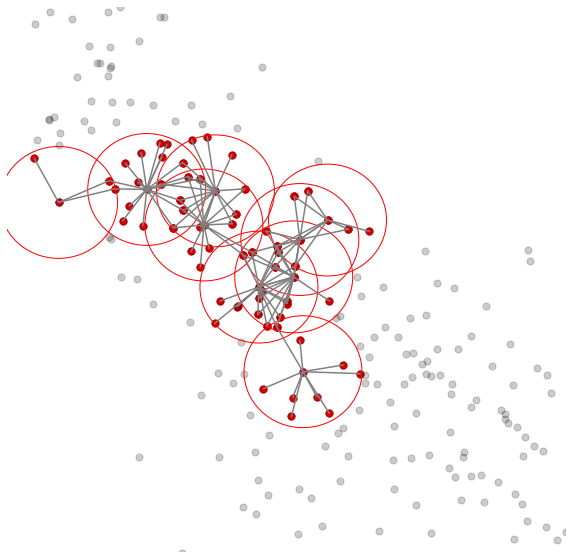

In [23]:
plt.figure(figsize=(10,10))

puntos = [241, 245, 246, 247, 248, 249, 250, 251, 252]
for i_x, color in zip(puntos, ['red' for i in range(len(puntos))]):
    plt.scatter(X[i_x, 0], X[i_x, 1], c='blue', s=50, alpha=0.8)
    circ = patches.Circle((X[i_x][0],X[i_x][1]),0.15, color='r', fill=False)
    plt.gca().add_patch(circ)
    plt.scatter(X[vecinos[i_x], 0], X[vecinos[i_x], 1], c=color, alpha = 0.8, s=50)
    for i in range(len(vecinos[i_x])):
        plt.plot(X[[i_x, vecinos[i_x][i]], 0], X[[i_x, vecinos[i_x][i]], 1], c='gray')
    plt.scatter(X[vecinos[i_x], 0], X[vecinos[i_x], 1], c=color, alpha = 0.8, s=50)
    
plt.scatter(X[:,0], X[:,1], alpha=0.2, c='black', s=50);

plt.xlim(np.min(xi_nn[i_x][:,0])-0.6,np.max(xi_nn[i_x][:,0])+0.6)
plt.ylim(np.min(xi_nn[i_x][:,1])-0.6,np.max(xi_nn[i_x][:,1])+0.6)
plt.grid(False)
plt.axis(False)
plt.show()

Definimos un clúster como un conjunto no vacío de puntos que satisface dos condiciones:

- Todos los puntos del clúster están densamente conectados entre sí
- Si un punto $p$ es densamente alcanzable desde otro punto $q$, entonces $p$ también forma parte del clúster

El ruido es simplemente todos aquellos puntos que no pertenecen a ningún clúster; **¿outliers?**

### Algoritmo

In [25]:
class DBSCAN:
    def __init__(self, X, eps, MinPts):
        self.X = X
        self.eps = eps
        self.MinPts = MinPts
        self.dist = pairwise_distances(self.X)
        self.clusters = []
        self.observaciones = {i:observacion(x, i) for i, x in enumerate(self.X)}
        
    def dbscan(self):
        for o in self.observaciones.values():
            if o.visited is False:
                o.visited = True
                vecinos = o.vecinos(self.dist, self.eps)
                if len(vecinos) < self.MinPts:
                    o.tipo = 'Ruido'
                else:
                    self.clusters.append(set())
                    self.expandir_cluster(o, vecinos)
            else:
                pass
            
    def expandir_cluster(self, o, vecinos):
        self.clusters[-1].add(o.index)
        for observ_vecina in vecinos:
            observ_vecina = self.observaciones[observ_vecina]
            if observ_vecina.visited is False:
                observ_vecina.visited = True
                vecinos_observ_vecina = observ_vecina.vecinos(self.dist, self.eps)
                if len(vecinos_observ_vecina) >= self.MinPts:
                    for obs in vecinos_observ_vecina:
                        vecinos.append(obs)
                        
            if observ_vecina not in [b for a in self.clusters for b in a]:
                self.clusters[-1].add(observ_vecina.index)
                
    def labels(self):
        clust_df = []
        for i in range(len(X)):
            for in_c, j in enumerate(dbs.clusters):
                if i in j:
                    clust_df.append(in_c)
                    break

            if len(clust_df) == i:
                clust_df.append(len(dbs.clusters))
        return clust_df
                
class observacion:
    def __init__(self, x, index, visited=False, tipo=None):
        self.index = index
        self.x = x
        self.visited = visited
        self.tipo = tipo
        
    def vecinos(self, dist, eps):
        return [index for index, d in enumerate(dist[self.index,:]) if d < eps]

In [26]:
dbs = DBSCAN(X, 0.14, 5)
dbs.dbscan()
df['clustering'] = dbs.labels()

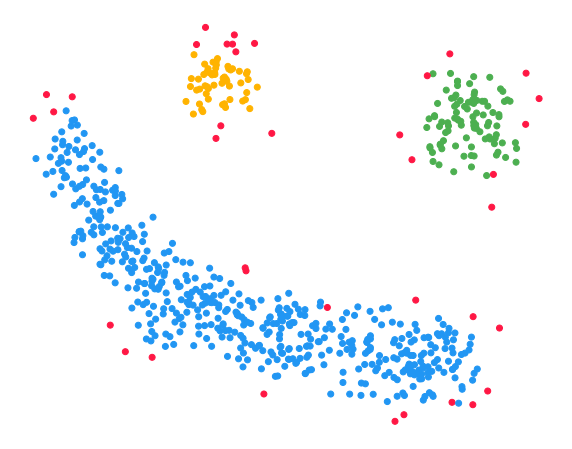

In [27]:
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = df.clustering.replace({0:'#FFB300', 1:'#4CAF50', 2:'#2196F3', 3:'#ff1744'}))
plt.grid(False)
plt.axis(False)
plt.show()

### Elección de hiperparámetros

Los parámetros iniciales de DBSCAN son $\epsilon$  (radio de la circunferencia) y $MinPts$ (valor de densidad aceptable para los puntos núcleo). Estos hiperparámetros son críticos ya que si escogemos un valor de $\epsilon$ demasiado grande, todos los puntos serán vecinos ya que la circunferencia podría abarcarlos a todos y se encontraría tan solo un clúster. Pero si $\epsilon$ es demasiado pequeño, cada observación solo tendría un único vecino (él mismo) y habrían tantos clústeres como observaciones.

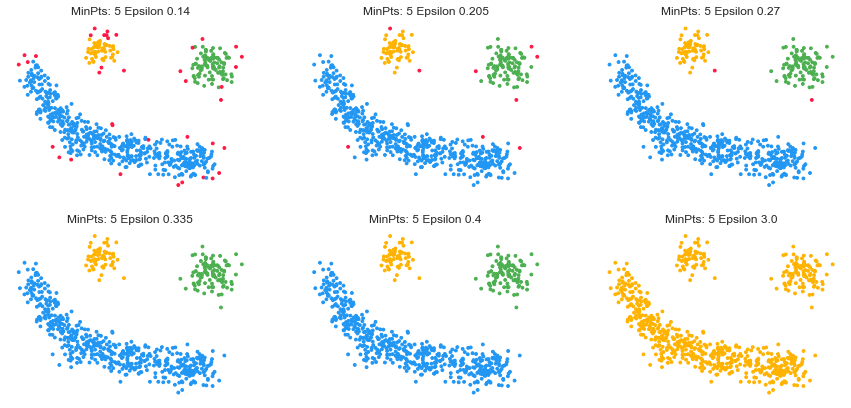

In [28]:
fig = plt.figure(figsize=(15,7))
for i, d in zip(range(1, 7), np.hstack((np.linspace(0.14, 0.4, 5), 3))):
    dbs = DBSCAN(X, d, 5)
    dbs.dbscan()
    df['clustering'] = dbs.labels()
    plt.subplot(2, 3, i)
    plt.scatter(X[:,0], X[:,1], s = 8, c = df.clustering.replace({0:'#FFB300', 1:'#4CAF50', 2:'#2196F3', 3:'#ff1744'}))
    plt.title('MinPts: {} Epsilon {}'.format(5, np.round(d,3)))
    plt.grid(False)
    plt.axis(False)

Una forma de calcular el número óptimo de clusters es ir variando el valor de $\epsilon$ y $MinPts$ en cada iteración y comparar estos valores frente al número de clusters encontrados o frente a la cantidad de ruido encontrado.

In [40]:
epsilons = np.round(np.linspace(0.00, 1, 20), 2)
clust_eps = []
ruido_eps = []
for ep in epsilons:
    dbs = DBSCAN(X, ep, 5)
    dbs.dbscan()
    clust_eps.append(len(dbs.clusters))
    ruido_eps.append(sum(1 for o in dbs.observaciones.values() if o.tipo == 'Ruido'))
    
min_pts = list(range(5, 20))
clust_min_pts = []
ruido_min_pts = []
for pts in min_pts:
    dbs = DBSCAN(X, 0.16, pts)
    dbs.dbscan()
    clust_min_pts.append(len(dbs.clusters))
    ruido_min_pts.append(sum(1 for o in dbs.observaciones.values() if o.tipo == 'Ruido'))

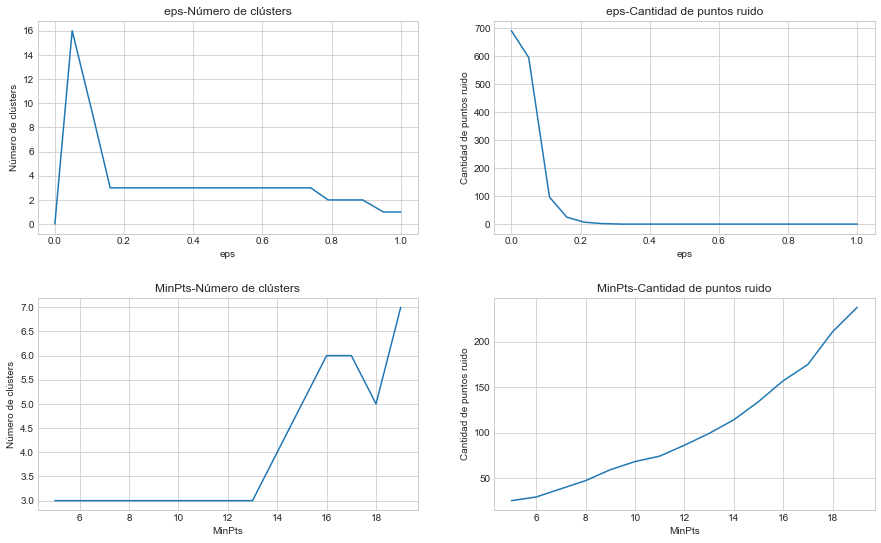

In [57]:
fig = plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace  =0.3)
for ind_plot, aux1, aux1_name, aux2, aux2_name in zip(range(1, 5), 
                         [epsilons, epsilons, min_pts, min_pts],
                         ['eps', 'eps', 'MinPts', 'MinPts'],
                         [clust_eps, ruido_eps, clust_min_pts, ruido_min_pts],
                         ['Número de clústers','Cantidad de puntos ruido','Número de clústers','Cantidad de puntos ruido']):
    plt.subplot(2, 2, ind_plot)
    plt.plot(aux1, aux2)
    plt.xlabel(aux1_name)
    plt.ylabel(aux2_name)
    plt.title('{}-{}'.format(aux1_name, aux2_name))
plt.show()
fig.savefig('hiperparametros-dbscan.png', transparent=True)

Como vemos, el valor óptimo para $\epsilon$ se encuentra entre 0.2 y 0.7, mientras que el valor óptimo para $MinPts$ sería de entre 5 y 13. Por otra parte, al aumentar el valor de $\epsilon$ se encuentra menos ruido, pero, al aumentar el valor de $MinPts$ ocurre lo contrario. 

---

#### Referencias

- <a href="https://github.com/drewwilimitis/Manifold-Learning/blob/master/Isomap.ipynb" target="_blank" rel="noopener">Isomap (Drew Wilimitis)</a>
- Data Science y redes complejas (Eloy Vicente Cestero y Alfonso Mateos Caballero)
- <a href="https://es.wikipedia.org/wiki/DBSCAN" target="_blank" rel="noopener">DBSCAN Wikipedia</a>
- Martin Ester, Hans-Peter Kriegel, Jiirg Sander, Xiaowei Xu. <a href="https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf" target="_blank" rel="noopener">A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise</a> (1996)